In [51]:
## ===============================================================
## Library Imports:
## ===============================================================
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Image display functionality
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from IPython.display import Image as disp

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Pixel Manipulation
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from PIL import Image

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Additional Libraries?
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#### Please insert other libraries as needed.

#### I recommend to use these as well; feel free to use different / remove if unnecessary
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

Path: .\figures\Bayes-pre-processed.png
File exists? True
Contents of 'figures': ['Bayes-bw-by-hand.png', 'Bayes-denoised.png', 'Bayes-noise.png', 'Bayes-pre-processed.png', 'Bayes.png', 'problem_statement_diagram.png']
Noisy image mode: 1
Noisy image size: (654, 489)
Clean image mode: RGBA
Clean image size: (654, 489)
Noisy pixels shape: (489, 654)
Unique values in noisy_pixels: [False  True]
y shape: (489, 654)
Unique values in y: [-1]
y shape: (489, 654)
Unique values in y: [-1  1]
Clean pixels shape: (489, 654)
Unique values in clean_pixels: [False  True]
Unique values in clean_binary: [-1  1]


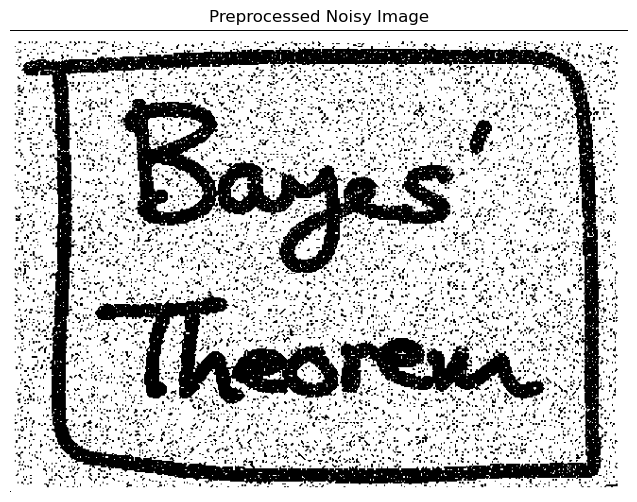

In [52]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Load images and convert to black and white
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Define the path to the preprocessed image
preprocessed_path = os.path.join(os.curdir, 'figures', 'Bayes-pre-processed.png')
print("Path:", preprocessed_path)
print("File exists?", os.path.exists(preprocessed_path))
print("Contents of 'figures':", os.listdir(os.path.join(os.curdir, 'figures')))

noisy_image = Image.open(preprocessed_path)
print("Noisy image mode:", noisy_image.mode)  # Expect "1" for a binary image or "L" if grayscale
print("Noisy image size:", noisy_image.size)

clean_path = os.path.join(os.curdir, 'figures', 'Bayes.png')
clean_image = Image.open(clean_path)
print("Clean image mode:", clean_image.mode)
print("Clean image size:", clean_image.size)

# Convert the noisy image to a numpy array
noisy_pixels = np.array(noisy_image)
print("Noisy pixels shape:", noisy_pixels.shape)
print("Unique values in noisy_pixels:", np.unique(noisy_pixels))

# Convert pixel values to model representation:
# Map 0 -> -1 (black) and 255 -> +1 (white)
y = np.where(noisy_pixels == 255, 1, -1)
print("y shape:", y.shape)
print("Unique values in y:", np.unique(y))

if noisy_pixels.dtype ==  np.bool_:
    y = np.where(noisy_pixels, 1, -1)
else:
    y = np.where(noisy_pixels == 255, 1, -1)
    
print("y shape:", y.shape)
print("Unique values in y:", np.unique(y))

# Initialize the recovered image 'x' with the observed noisy image 'y'
x = np.copy(y)

clean_blackwhite = clean_image.convert(mode="1", dither=0)
clean_pixels = np.array(clean_blackwhite)
print("Clean pixels shape:", clean_pixels.shape)
print("Unique values in clean_pixels:", np.unique(clean_pixels))

if clean_pixels.dtype == np.bool_:
    clean_binary = np.where(clean_pixels, 1, -1)
else: 
    clean_binary = np.where(clean_pixels == 255, 1, -1)
print("Unique values in clean_binary:", np.unique(clean_binary))

plt.figure(figsize=(8,6))
plt.imshow(noisy_pixels, cmap='gray')
plt.title("Preprocessed Noisy Image")
plt.axis('off')
plt.show()

In [53]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Function to get change in Energy if pixel is flipped
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def delta_energy(x, y, i, j, h, beta, eta):
    """ 
    x is a 2D numpy array of current recov'd img -1 to 1, and y is @D numpy arr of obs noisy
    """
    current_value = x[i,j]
    
    neighbor_sum = 0
    height, width = x.shape
    
    #Up, down, L and R neighbors (if not on edges)
    if i>0:
        neighbor_sum += x[i-1, j]
    if i< height-1:
        neighbor_sum += x[i+1, j]
    if j>0:
        neighbor_sum += x[i, j-1]
    if j<width-1:
        neighbor_sum += x[i, j+1]
    
    return 2 * current_value * (-h + eta * y[i,j] + beta * neighbor_sum)

Initial distribution in y: {-1: 86465, 1: 233341}
x_recovered shape: (489, 654)


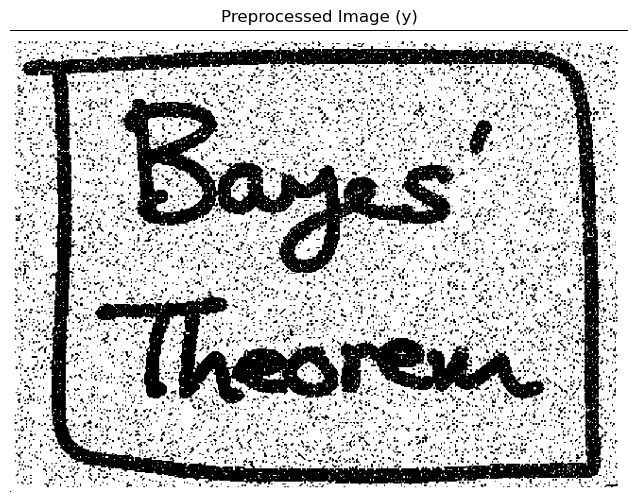

In [54]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Coordinate Descent to minimize energy function
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
""" 
Let x be curr est of clean img numpy arr, y sam eas before
We will return recovered img after convergence
"""
def coordinate_descent(x, y, h, beta, eta, max_iterations=300):
    
    num_iterations = 0
    height, width = x.shape
    total_flips = 0

    #Looping until max iterations or convergence
    while num_iterations < max_iterations:
        flips_in_iteration = 0
        for i in range(height):
            for j in range(width):
                delta_E = delta_energy(x, y, i, j, h, beta, eta)
                if delta_E < 0:
                    x[i, j] = -x[i, j]
                    flips_in_iteration += 1
                    total_flips += 1
        num_iterations += 1
        
        if flips_in_iteration == 0:
            break
        print("Iteration {}: # of Pixel Flips = {}".format(num_iterations, flips_in_iteration))
    return x, num_iterations, total_flips

unique, counts = np.unique(y, return_counts=True)
print("Initial distribution in y:", dict(zip(unique, counts)))

x = np.array(x)
x_recovered = np.copy(x) #Makes a copy of init est x (initialized to y)
print("x_recovered shape:", x_recovered.shape)

# Display the preprocessed image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(y, cmap='gray', vmin=-1, vmax=1)
plt.title("Preprocessed Image (y)")
plt.axis('off')
plt.show()

In [55]:
#Randomized Update Order

def coordinate_descent_random(x, y, h, beta, eta, max_iterations=300):
    num_iterations=0
    total_flips=0
    height, width = x.shape
    while num_iterations < max_iterations:
        flips_in_iteration=0
        #Create & shuff list of all indices
        indices = [(i,j) for i in range(height) for j in range(width)]
        np.random.shuffle(indices)
        for i,j in indices:
            delta_E = delta_energy(x, y, i, j, h, beta, eta)
            if delta_E<0:
                x[i,j] = -x[i,j]
                flips_in_iteration += 1
                total_flips += 1
        num_iterations += 1
        if flips_in_iteration == 0:
            break
    return x, num_iterations, total_flips

def coordinate_descent_annealing(x, y, h, beta, eta, max_iterations=300, initial_T=1.0):
    #A pixel is flipped if delta_E < 0 or with probability exp(-delta_E/T) when delta_EE >= 0.
    #Temperature T decreases with iterations.

    num_iterations = 0
    total_flips = 0
    height, width = x.shape
    while num_iterations < max_iterations:
        T = initial_T / (num_iterations + 1)  # Decrease temperature over time
        flips_in_iteration = 0
        for i in range(height):
            for j in range(width):
                dE = delta_energy(x, y, i, j, h, beta, eta)
                # Always flip if energy decreases; else flip with probability exp(-delta_E/T)
                if dE < 0 or np.random.rand() < np.exp(-dE / T):
                    x[i, j] = -x[i, j]
                    flips_in_iteration += 1
                    total_flips += 1
        num_iterations += 1
        if flips_in_iteration == 0:
            break
    return x, num_iterations, total_flips

In [56]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Eval Recovery Rate
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def recovery_rate(recovered, clean): 
    total_pixels = recovered.size
    correct_pixels = np.sum(recovered==clean)
    rate = (correct_pixels/total_pixels) * 100
    return rate

rate = recovery_rate(x_recovered, clean_binary)
print("Recovery Rate: {:.2f}%".format(rate))

Recovery Rate: 89.97%


In [57]:
def coordinate_descent_multi(y, h, beta, eta, clean_binary, num_restarts=5,
                            max_iterations=300, perturb_prob=0.05, method='baseline'):
    #Goal here is to run w/ mult random restarts, each perturbs initialization flipping small frac of pixels
    #Returns best recovery rate, best recovered image
    best_rate = 0.0
    best_x = None
    best_details = None
    for restart in range(num_restarts):
        x0 = np.copy(y)
        # Perturb the initial state: with probability 'perturb_prob', flip the pixel
        perturb_mask = np.random.rand(*x0.shape) < perturb_prob
        x0[perturb_mask] = -x0[perturb_mask]
        if method == "baseline":
            x_rec, iters, flips = coordinate_descent(x0, y, h, beta, eta, max_iterations)
        elif method == "random":
            x_rec, iters, flips = coordinate_descent_random(x0, y, h, beta, eta, max_iterations)
        elif method == "annealing":
            x_rec, iters, flips = coordinate_descent_annealing(x0, y, h, beta, eta, max_iterations, initial_T=1.0)
        else:
            raise ValueError("Invalid method specified")
        rate = recovery_rate(x_rec, clean_binary)
        print(f"Restart {restart+1} (method {method}): Recovery rate = {rate:.2f}% (iters: {iters}, flips: {flips})")
        if rate > best_rate:
            best_rate = rate
            best_x = x_rec.copy()
            best_details = (iters, flips)
    return best_x, best_rate, best_details

In [58]:

print("=== Baseline Coordinate Descent with Multiple Restarts ===")
best_x_baseline, best_rate_baseline, details_baseline = coordinate_descent_multi(
    y, h=0.0, beta=1.0, eta=1.0, clean_binary=clean_binary,
    num_restarts=5, max_iterations=100, perturb_prob=0.05, method="baseline")
print(f"Best baseline recovery: {best_rate_baseline:.2f}% (iters, flips: {details_baseline})\n")

print("=== Randomized Update Order with Multiple Restarts ===")
best_x_random, best_rate_random, details_random = coordinate_descent_multi(
    y, h=0.0, beta=1.0, eta=1.0, clean_binary=clean_binary,
    num_restarts=5, max_iterations=100, perturb_prob=0.05, method="random")
print(f"Best randomized recovery: {best_rate_random:.2f}% (iters, flips: {details_random})\n")

print("=== Simulated Annealing with Multiple Restarts ===")
best_x_annealing, best_rate_annealing, details_annealing = coordinate_descent_multi(
    y, h=0.0, beta=1.0, eta=1.0, clean_binary=clean_binary,
    num_restarts=5, max_iterations=500, perturb_prob=0.05, method="annealing")
print(f"Best annealing recovery: {best_rate_annealing:.2f}% (iters, flips: {details_annealing})\n")

=== Baseline Coordinate Descent with Multiple Restarts ===
Iteration 1: # of Pixel Flips = 28329
Iteration 2: # of Pixel Flips = 1948
Iteration 3: # of Pixel Flips = 251
Iteration 4: # of Pixel Flips = 62
Iteration 5: # of Pixel Flips = 14
Iteration 6: # of Pixel Flips = 6
Iteration 7: # of Pixel Flips = 3
Iteration 8: # of Pixel Flips = 1
Iteration 9: # of Pixel Flips = 1
Iteration 10: # of Pixel Flips = 1
Restart 1 (method baseline): Recovery rate = 94.73% (iters: 11, flips: 30616)
Iteration 1: # of Pixel Flips = 28347
Iteration 2: # of Pixel Flips = 1961
Iteration 3: # of Pixel Flips = 213
Iteration 4: # of Pixel Flips = 37
Iteration 5: # of Pixel Flips = 7
Iteration 6: # of Pixel Flips = 4
Iteration 7: # of Pixel Flips = 2
Restart 2 (method baseline): Recovery rate = 94.72% (iters: 8, flips: 30571)
Iteration 1: # of Pixel Flips = 28303
Iteration 2: # of Pixel Flips = 1983
Iteration 3: # of Pixel Flips = 226
Iteration 4: # of Pixel Flips = 44
Iteration 5: # of Pixel Flips = 11
Itera

KeyboardInterrupt: 

Recovered image saved to: .\figures\Bayes-denoised.png


<function matplotlib.pyplot.show(close=None, block=None)>

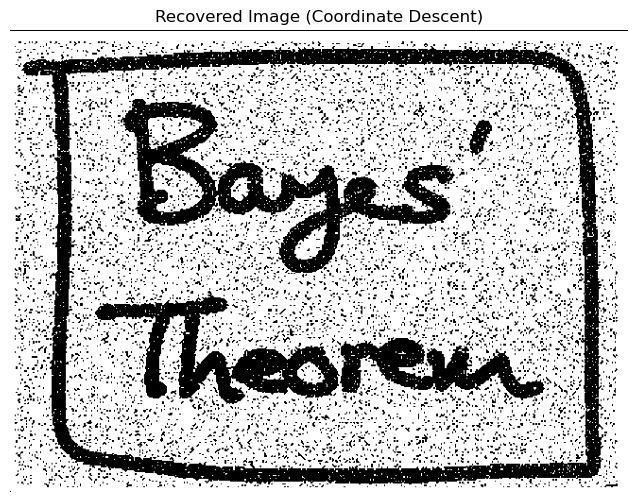

In [ ]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Save Denoised Img and display
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#Convert binary image back to normal 255
recovered_pixels = np.where(x_recovered==1, 255, 0).astype(np.uint8)

recovered_image = Image.fromarray(recovered_pixels) #Creating PIL img from numpy

output_path = os.path.join(os.curdir, 'figures', 'Bayes-denoised.png')
recovered_image.save(output_path)
print("Recovered image saved to:", output_path)

#Displaying using grayscale colormap
plt.figure(figsize=(8,6))
imgplot = plt.imshow(x_recovered, cmap = 'gray', vmin=-1, vmax=1)
plt.title("Recovered Image (Coordinate Descent)")
plt.axis('off')
plt.show